In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nussl
from utils import viz, data
import yaml
import os

In [6]:
import json
from nussl.datasets import transforms as nussl_tfm
from pathlib import Path

In [7]:
from models.MaskInference import MaskInference
from models.UNet import UNetSpect
from models.Filterbank import Filterbank
nussl.ml.register_module(MaskInference)
nussl.ml.register_module(UNetSpect)
nussl.ml.register_module(Filterbank)

In [8]:
os.listdir('models/')

['ST_mask_0.1dropout',
 '.ipynb_checkpoints',
 'ST_mask_1e-4LR',
 'ST_mask_256hop',
 'ST_unet_16f_v2',
 '__pycache__',
 'ST_mask_2048w',
 'filterbank_5e-3LR',
 'MaskInference.py',
 'filterbank_3L_0.5P',
 'ST_mask_64hop',
 'ST_mask_0.7dropout',
 'Waveform.py',
 'UNet.py',
 'ST_unet_8f',
 'Filterbank.py',
 'ST_mask_1layer',
 'filterbank_1e-3LR',
 'ST_mask_1e-2LR',
 'ST_mask_0.5dropout',
 'filterbank_3L_0.5P_32f',
 'ST_mask_128w',
 'ST_mask_25h',
 'ST_mask_5layer',
 'ST_mask_100h',
 'filterbank',
 'ST_unet_32f',
 'filterbank_3L_0.5P_16f',
 'Clustering.py',
 'ST_mask_3L_0.5P',
 'ST_unet_16f',
 'ST_mask_3layer',
 'ST_mask_tutorial_defaults']

In [18]:
model_name = 'filterbank_3L_0.5P'

In [19]:
model_path = 'models/'+model_name+'/checkpoints/latest.model.pth'
config_path = 'models/'+model_name+'/configs.yml'
#Optimizer checkpoints no longer stored
#optimizer_path = 'models/'+model_name+'/checkpoints/latest.optimizer.pth'

In [20]:
#Load yaml configs into configs dictionary
with open(config_path,'r') as f:
    configs = yaml.safe_load(f)
    f.close()

model_type = configs['model_type']
waveform_models = ['Filterbank']
if model_type in waveform_models:
    stft_params = None
    
    separator = nussl.separation.deep.DeepAudioEstimation(
        nussl.AudioSignal(), model_path=model_path,
        device='cpu',
    )
else:
    stft_params = nussl.STFTParams(**configs['stft_params'])
    
    separator = nussl.separation.deep.DeepMaskEstimation(
        nussl.AudioSignal(), model_path=model_path,
        device='cpu',
    )

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


In [21]:
model_checkpoint = torch.load(model_path,map_location=torch.device('cpu'))
#Optimizer checkpoints no longer stored
#optimizer_checkpoint = torch.load(optimizer_path,map_location=torch.device('cpu'))

In [22]:
model_checkpoint['metadata']['trainer.state_dict']

{'epoch': 15,
 'epoch_length': 25,
 'max_epochs': 15,
 'output': {'loss': 0.0025881181936711073},
 'metrics': {'avg_loss': 0.002660773752392299},
 'seed': None}

In [23]:
val_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['validation/loss']
train_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['train/loss']
n_epochs = model_checkpoint['metadata']['trainer.state_dict']['epoch']

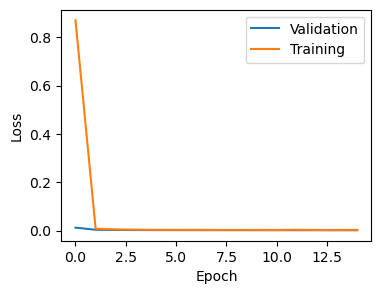

In [24]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,val_loss,label='Validation')
plt.plot(x,train_loss,label='Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

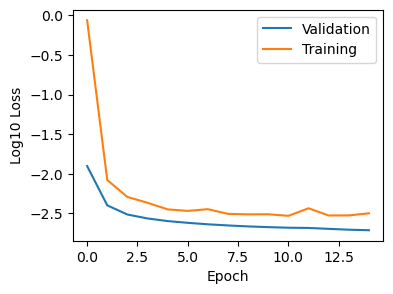

In [25]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,np.log10(val_loss),label='Validation')
plt.plot(x,np.log10(train_loss),label='Training')
plt.ylabel('Log10 Loss')
plt.xlabel('Epoch')
plt.legend()

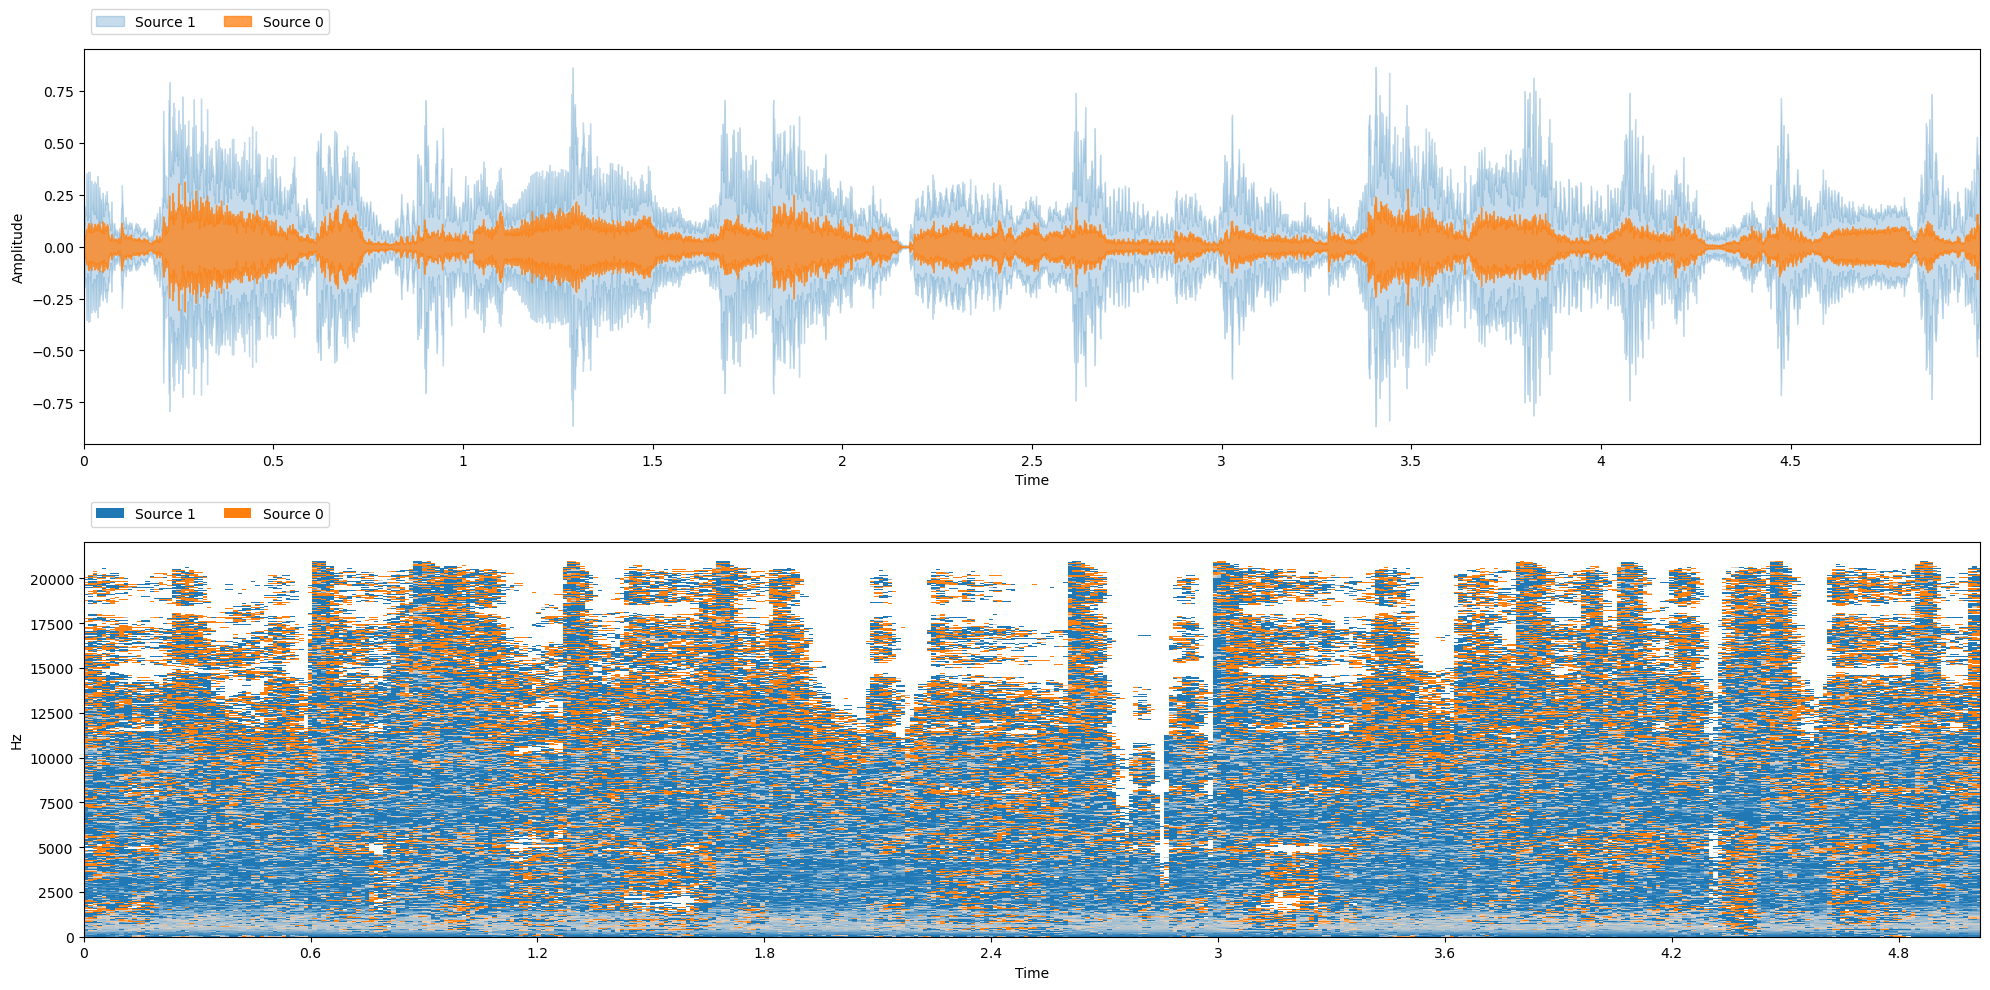


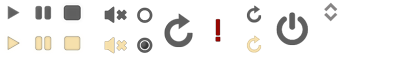
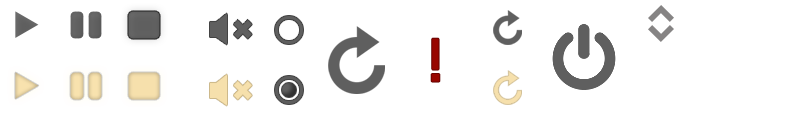
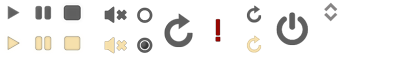

In [26]:
#Test on the data
test_folder = configs['test_folder']
tfm = None
test_data = data.mixer(stft_params, transform=tfm, fg_path=configs['test_folder'], num_mixtures=50, coherent_prob=1.0, duration=5)

item = test_data[1]
separator.audio_signal = item['mix']
estimates = separator()
estimates.append(item['mix'] - estimates[0])

viz.show_sources(estimates)